In [ ]:
!pip install casadi
!pip install control

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.6/549.6 kB 7.5 MB/s eta 0:00:00


<ipython-input-2-e2c2e9b4ff80>:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Theta[i, j] = C @ np.linalg.matrix_power(A, i-j) @ B



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



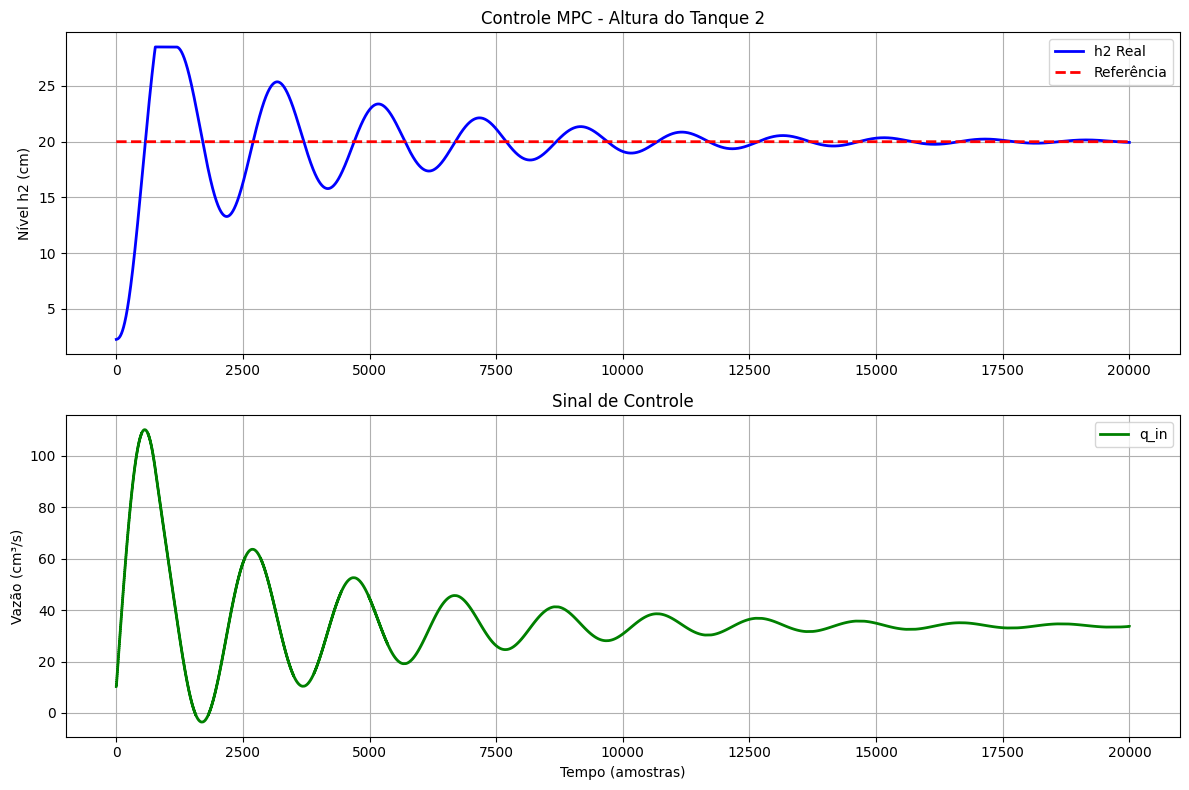

In [ ]:
import numpy as np
import control as ct
from casadi import Opti, DM
import matplotlib.pyplot as plt

# =======================
# Parâmetros do Sistema
# =======================
alpha1 = 0.56
alpha2 = 0.30
s1 = 0.50       # cm²
s2 = 0.50       # cm²
g = 980.665     # cm/s²
R = 14.85       # cm
q_in = 10       # cm³/s (controle inicial)

# Pontos de equilíbrio (valores do sistema em regime estacionário)
h1_ss = 0.650813
h2_ss = 2.265876

# Definir limites para h2 (altura do tanque 2)
# Suponha que o valor máximo do tanque seja, por exemplo, 2.5 cm
h2_max_allowed = 30      # cm (valor máximo definido)
h2_min_allowed = 0.05 * h2_max_allowed  # 5% do valor máximo
h2_max_lim   = 0.95 * h2_max_allowed      # 95% do valor máximo

# =======================
# Matrizes do Modelo Contínuo
# =======================
# Cálculos conforme suas fórmulas:
A11 = -(alpha1 * s1 * np.sqrt(2*g*h1_ss)) / (2 * h1_ss * np.pi * (2*R*h1_ss - h1_ss**2))
A12 = 0.0
A21 = (alpha1 * s1 * np.sqrt(2*g*h1_ss)) / (np.pi * (2*R*h2_ss - h2_ss**2))
A22 = -(alpha2 * s2 * np.sqrt(2*g*h2_ss)) / (2 * h2_ss * np.pi * (2*R*h2_ss - h2_ss**2))

A = np.array([[A11, A12],
              [A21, A22]], dtype=float)

B11 = 1 / (np.pi * (2*R*h1_ss - h1_ss**2))
B = np.array([[B11],
              [0.0]], dtype=float)

C = np.array([[0, 1]], dtype=float)   # Mede apenas h2
D = np.array([[0.0]])

# Criação do sistema de espaço de estados contínuo
sys_cont = ct.ss(A, B, C, D)
dt = 0.1  # Período de amostragem
sysd = ct.c2d(sys_cont, dt, method='zoh')

A_d = np.array(sysd.A, dtype=float)
B_d = np.array(sysd.B, dtype=float)
C_d = np.array(sysd.C, dtype=float)

# =======================
# Configuração do MPC
# =======================
Hp = 20  # Horizonte de predição
Hc = 3   # Horizonte de controle
Q_val = 100  # Peso do erro de rastreamento (alta penalização para erro em h2)
R_val = 10     # Peso do esforço de controle

# Função para construir as matrizes de predição Phi e Theta
def construir_matrizes_predicao(A, B, C, Hp, Hc):
    n_states = A.shape[0]
    n_inputs = B.shape[1]

    Phi = np.zeros((Hp, n_states))
    Theta = np.zeros((Hp, Hc))

    for i in range(Hp):
        Phi[i, :] = C @ np.linalg.matrix_power(A, i+1)

    for j in range(Hc):
        for i in range(j, Hp):
            Theta[i, j] = C @ np.linalg.matrix_power(A, i-j) @ B
    return Phi, Theta

Phi, Theta = construir_matrizes_predicao(A_d, B_d, C_d, Hp, Hc)

# =======================
# Formulação QP com CasADi
# =======================
opti = Opti()

# Variável de decisão: DeltaU (incrementos de controle) - vetor de tamanho Hc
DeltaU = opti.variable(Hc)

# Parâmetros: estado atual x_k (2 elementos) e trajetória de referência Y_ref (Hp elementos)
x_k = opti.parameter(2)
Y_ref = opti.parameter(Hp)

# Converter as matrizes para tipo DM (CasADi)
Phi_cas = DM(Phi)
Theta_cas = DM(Theta)
Q_bar = DM(Q_val * np.eye(Hp))
R_bar = DM(R_val * np.eye(Hc))

# Resposta livre (sem controle incremental)
Y_free = Phi_cas @ x_k
# Predição: Y = Y_free + Theta * DeltaU
# Erro: E = Y - Y_ref
E = Y_free + Theta_cas @ DeltaU - Y_ref

# Função de custo (ignorando o termo constante):
J = E.T @ Q_bar @ E + DeltaU.T @ R_bar @ DeltaU
opti.minimize(J)

# Restrições no controle incremental (aumentar intervalo para maior flexibilidade)
opti.subject_to(opti.bounded(-5, DeltaU, 5))

# Configurar o solver
opts = {'ipopt.print_level': 0, 'print_time': 0}
opti.solver('ipopt', opts)

# =======================
# Simulação
# =======================
N_sim = 20000
x_hist = np.zeros((N_sim+1, 2))
u_hist = np.zeros(N_sim)
ref_hist = np.zeros(N_sim+1)

# Condição inicial
x0 = np.array([h1_ss, h2_ss])
x_hist[0, :] = x0

# Definir o set-point desejado para h2
ref = 20
ref_hist[:] = ref

# Controle incremental: inicie com u_prev = q_in (controle absoluto inicial)
u_prev = q_in

for k in range(N_sim):
    # Atualizar parâmetros: estado atual e referência constante (trajetória de Hp passos iguais)
    opti.set_value(x_k, x_hist[k, :])
    opti.set_value(Y_ref, ref * np.ones(Hp))

    try:
        sol = opti.solve()
        delta_u_opt = sol.value(DeltaU)[0]  # utiliza apenas o primeiro incremento
    except Exception as e:
        print(f"O solver falhou na iteração {k}: {e}")
        delta_u_opt = 0.0

    # Atualização incremental do controle
    u_new = u_prev + delta_u_opt
    u_hist[k] = u_new

    # Atualização do estado: x[k+1] = A_d * x[k] + B_d * u_new
    x_next = A_d @ x_hist[k, :].reshape(-1, 1) + B_d * u_new
    x_next = x_next.flatten()

    # Aplicar restrição física para h2 (o segundo estado)
    x_next[1] = np.clip(x_next[1], h2_min_allowed, h2_max_lim)

    x_hist[k+1, :] = x_next
    u_prev = u_new

# =======================
# Visualização dos Resultados
# =======================
plt.figure(figsize=(12,8))

# Gráfico do nível de h2 e do set-point
plt.subplot(2,1,1)
plt.plot(x_hist[:, 1], 'b-', linewidth=2, label='h2 Real')
plt.plot(ref_hist, 'r--', linewidth=2, label='Referência')
plt.ylabel('Nível h2 (cm)')
plt.title('Controle MPC - Altura do Tanque 2')
plt.legend()
plt.grid(True)

# Gráfico do sinal de controle (vazão)
plt.subplot(2,1,2)
plt.step(np.arange(N_sim), u_hist, 'g-', linewidth=2, where='post', label='q_in')
plt.ylabel('Vazão (cm³/s)')
plt.xlabel('Tempo (amostras)')
plt.title('Sinal de Controle')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
print(Theta)

NameError: name 'Theta' is not defined

In [ ]:
Tentando fazer ser dinamico

In [ ]:
import numpy as np
import control as ct
from casadi import Opti, DM
import matplotlib.pyplot as plt

# =======================
# Parâmetros do Sistema
# =======================
alpha1 = 0.56
alpha2 = 0.30
s1 = 0.50       # cm²
s2 = 0.50       # cm²
g = 980.665     # cm/s²
R = 14.85       # cm
q_in = 10       # cm³/s (controle inicial)

# Pontos de equilíbrio (valores do sistema em regime estacionário)
h1_ss = 0.650813
h2_ss = 2.265876

# Limites para h2 (altura do tanque 2)
# Suponha que o valor máximo do tanque seja, por exemplo, 30 cm
h2_max_allowed = 30      # cm (valor máximo definido)
h2_min_allowed = 0.05 * h2_max_allowed  # 5% do valor máximo
h2_max_lim   = 0.95 * h2_max_allowed      # 95% do valor máximo

# =======================
# Matrizes do Modelo Contínuo
# =======================
# Cálculos conforme as fórmulas:
A11 = -(alpha1 * s1 * np.sqrt(2*g*h1_ss)) / (2 * h1_ss * np.pi * (2*R*h1_ss - h1_ss**2))
A12 = 0.0
A21 = (alpha1 * s1 * np.sqrt(2*g*h1_ss)) / (np.pi * (2*R*h2_ss - h2_ss**2))
A22 = -(alpha2 * s2 * np.sqrt(2*g*h2_ss)) / (2 * h2_ss * np.pi * (2*R*h2_ss - h2_ss**2))

A = np.array([[A11, A12],
              [A21, A22]], dtype=float)

B11 = 1 / (np.pi * (2*R*h1_ss - h1_ss**2))
B = np.array([[B11],
              [0.0]], dtype=float)

C = np.array([[0, 1]], dtype=float)   # Mede apenas h2
D = np.array([[0.0]])

# Criação do sistema de espaço de estados contínuo
sys_cont = ct.ss(A, B, C, D)
dt = 0.1  # Período de amostragem
sysd = ct.c2d(sys_cont, dt, method='zoh')

A_d = np.array(sysd.A, dtype=float)
B_d = np.array(sysd.B, dtype=float)
C_d = np.array(sysd.C, dtype=float)

# =======================
# Configuração do MPC
# =======================
Hp = 20  # Horizonte de predição
Hc = 3   # Horizonte de controle
Q_val =100  # Peso do erro de rastreamento (alta penalização para erro em h2)
R_val = 10     # Peso do esforço de controle (valor fixo usado para a formulação QP)

# Função para construir as matrizes de predição Phi e Theta
def construir_matrizes_predicao(A, B, C, Hp, Hc):
    n_states = A.shape[0]
    n_inputs = B.shape[1]

    Phi = np.zeros((Hp, n_states))
    Theta = np.zeros((Hp, Hc))

    for i in range(Hp):
        Phi[i, :] = C @ np.linalg.matrix_power(A, i+1)

    for j in range(Hc):
        for i in range(j, Hp):
            Theta[i, j] = C @ np.linalg.matrix_power(A, i-j) @ B
    return Phi, Theta

Phi, Theta = construir_matrizes_predicao(A_d, B_d, C_d, Hp, Hc)

# =======================
# Formulação QP com CasADi
# =======================
opti = Opti()

# Variável de decisão: DeltaU (incrementos de controle) - vetor de tamanho Hc
DeltaU = opti.variable(Hc)

# Parâmetros: estado atual x_k (2 elementos) e trajetória de referência Y_ref (Hp elementos)
x_k = opti.parameter(2)
Y_ref = opti.parameter(Hp)

# Converter as matrizes para tipo DM (CasADi)
Phi_cas = DM(Phi)
Theta_cas = DM(Theta)
Q_bar = DM(Q_val * np.eye(Hp))
R_bar = DM(R_val * np.eye(Hc))

# Resposta livre (sem controle incremental)
Y_free = Phi_cas @ x_k
# Predição: Y = Y_free + Theta * DeltaU
# Erro: E = Y - Y_ref
E = Y_free + Theta_cas @ DeltaU - Y_ref

# Função de custo (ignorando o termo constante):
J = E.T @ Q_bar @ E + DeltaU.T @ R_bar @ DeltaU
opti.minimize(J)

# Restrições no controle incremental (aumentar intervalo para maior flexibilidade)
opti.subject_to(opti.bounded(-5, DeltaU, 5))

# Configurar o solver
opts = {'ipopt.print_level': 0, 'print_time': 0}
opti.solver('ipopt', opts)

# =======================
# Simulação
# =======================
N_sim = 60000
x_hist = np.zeros((N_sim+1, 2))
u_hist = np.zeros(N_sim)
ref_hist = np.zeros(N_sim+1)

# Condição inicial
x0 = np.array([h1_ss, h2_ss])
x_hist[0, :] = x0

# Controle incremental: inicie com u_prev = q_in (controle absoluto inicial)
u_prev = q_in

# Para simular um degrau, definimos o perfil de referência ao longo do tempo.
# Exemplo:
# - Para k < N_sim/3, ref = 10;
# - Para N_sim/3 <= k < 2*N_sim/3, ref = 15;
# - Para k >= 2*N_sim/3, ref = 20.
for k in range(N_sim):
    # Define a referência para este instante, conforme a posição no tempo:
    if k < N_sim/3:
        ref_val = 2
    elif k < 2*N_sim/3:
        ref_val = 3
    else:
        ref_val = 4

    ref_hist[k] = ref_val

    # Atualizar parâmetros: estado atual e referência para o horizonte de predição
    opti.set_value(x_k, x_hist[k, :])
    opti.set_value(Y_ref, ref_val * np.ones(Hp))

    try:
        sol = opti.solve()
        delta_u_opt = sol.value(DeltaU)[0]  # utiliza apenas o primeiro incremento
    except Exception as e:
        print(f"O solver falhou na iteração {k}: {e}")
        delta_u_opt = 0.0

    # Atualização incremental do controle
    u_new = u_prev + delta_u_opt
    u_hist[k] = u_new

    # Atualização do estado: x[k+1] = A_d * x[k] + B_d * u_new
    x_next = A_d @ x_hist[k, :].reshape(-1, 1) + B_d * u_new
    x_next = x_next.flatten()

    # Aplicar restrição física para h2 (o segundo estado)
    x_next[1] = np.clip(x_next[1], h2_min_allowed, h2_max_lim)

    x_hist[k+1, :] = x_next
    u_prev = u_new

# Preenche o último ponto do perfil de referência
ref_hist[-1] = ref_hist[-2]

# =======================
# Visualização dos Resultados
# =======================
plt.figure(figsize=(12,8))

# Gráfico do nível de h2 e do set-point
plt.subplot(2,1,1)
plt.plot(x_hist[:, 1], 'b-', linewidth=2, label='h2 Real')
plt.plot(ref_hist, 'r--', linewidth=2, label='Referência')
plt.ylabel('Nível h2 (cm)')
plt.title('Controle MPC - Altura do Tanque 2')
plt.legend()
plt.grid(True)

# Gráfico do sinal de controle (vazão)
plt.subplot(2,1,2)
plt.step(np.arange(N_sim), u_hist, 'g-', linewidth=2, where='post', label='q_in')
plt.ylabel('Vazão (cm³/s)')
plt.xlabel('Tempo (amostras)')
plt.title('Sinal de Controle')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


<ipython-input-10-3f424c3d7f94>:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Theta[i, j] = C @ np.linalg.matrix_power(A, i-j) @ B
CasADi - 2025-02-11 23:08:39 WARNING("KeyboardInterruptException") [.../casadi/interfaces/ipopt/ipopt_nlp.cpp:132]


O solver falhou na iteração 58299: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:165:
.../casadi/core/optistack_internal.cpp:1030: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'NonIpopt_Exception_Thrown'


CasADi - 2025-02-11 23:08:40 WARNING("KeyboardInterruptException") [.../casadi/interfaces/ipopt/ipopt_nlp.cpp:95]


O solver falhou na iteração 58466: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:165:
.../casadi/core/optistack_internal.cpp:1030: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'NonIpopt_Exception_Thrown'


CasADi - 2025-02-11 23:08:41 WARNING("KeyboardInterruptException") [.../casadi/interfaces/ipopt/ipopt_nlp.cpp:132]


O solver falhou na iteração 58671: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:165:
.../casadi/core/optistack_internal.cpp:1030: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'NonIpopt_Exception_Thrown'


CasADi - 2025-02-11 23:08:43 WARNING("KeyboardInterruptException") [.../casadi/interfaces/ipopt/ipopt_nlp.cpp:114]


O solver falhou na iteração 58785: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:165:
.../casadi/core/optistack_internal.cpp:1030: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'NonIpopt_Exception_Thrown'


Tempo total da simulação: 314.260 segundos
Tempo médio por iteração: 0.005238 segundos


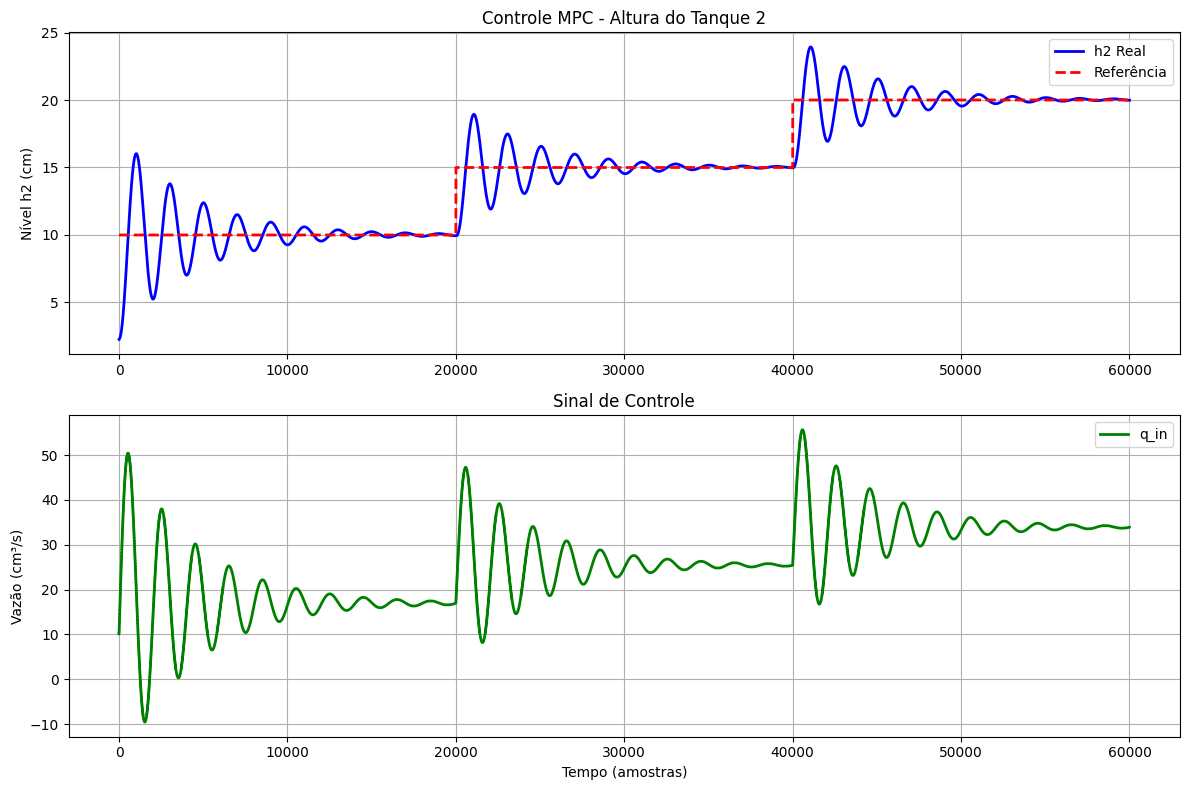

In [ ]:
import time

# Inicia a medição de tempo
start_time = time.time()

# =======================
# SIMULAÇÃO (CÓDIGO PRINCIPAL)
# =======================

N_sim = 60000
x_hist = np.zeros((N_sim+1, 2))
u_hist = np.zeros(N_sim)
ref_hist = np.zeros(N_sim+1)

# Condição inicial
x0 = np.array([h1_ss, h2_ss])
x_hist[0, :] = x0

# Controle incremental: inicie com u_prev = q_in (controle absoluto inicial)
u_prev = q_in

# Para simular um degrau variável, definimos o perfil de referência:
# - Para k < N_sim/3, ref = 10;
# - Para N_sim/3 <= k < 2*N_sim/3, ref = 15;
# - Para k >= 2*N_sim/3, ref = 20.
for k in range(N_sim):
    if k < N_sim/3:
        ref_val = 10
    elif k < 2 * N_sim/3:
        ref_val = 15
    else:
        ref_val = 20
    ref_hist[k] = ref_val

    # Atualiza os parâmetros do MPC
    opti.set_value(x_k, x_hist[k, :])
    opti.set_value(Y_ref, ref_val * np.ones(Hp))

    try:
        sol = opti.solve()
        delta_u_opt = sol.value(DeltaU)[0]  # utiliza apenas o primeiro incremento
    except Exception as e:
        print(f"O solver falhou na iteração {k}: {e}")
        delta_u_opt = 0.0

    # Atualização incremental do controle
    u_new = u_prev + delta_u_opt
    u_hist[k] = u_new

    # Atualização do estado: x[k+1] = A_d * x[k] + B_d * u_new
    x_next = A_d @ x_hist[k, :].reshape(-1, 1) + B_d * u_new
    x_next = x_next.flatten()

    # Aplicar restrição física para h2 (o segundo estado)
    x_next[1] = np.clip(x_next[1], h2_min_allowed, h2_max_lim)

    x_hist[k+1, :] = x_next
    u_prev = u_new

# Preenche o último ponto do perfil de referência
ref_hist[-1] = ref_hist[-2]

# =======================
# FIM DA SIMULAÇÃO
# =======================

# Finaliza a medição de tempo
end_time = time.time()
total_time = end_time - start_time
avg_iter_time = total_time / N_sim

print(f"Tempo total da simulação: {total_time:.3f} segundos")
print(f"Tempo médio por iteração: {avg_iter_time:.6f} segundos")

# Visualização dos Resultados
plt.figure(figsize=(12,8))

# Gráfico do nível de h2 e do set-point
plt.subplot(2,1,1)
plt.plot(x_hist[:, 1], 'b-', linewidth=2, label='h2 Real')
plt.plot(ref_hist, 'r--', linewidth=2, label='Referência')
plt.ylabel('Nível h2 (cm)')
plt.title('Controle MPC - Altura do Tanque 2')
plt.legend()
plt.grid(True)

# Gráfico do sinal de controle (vazão)
plt.subplot(2,1,2)
plt.step(np.arange(N_sim), u_hist, 'g-', linewidth=2, where='post', label='q_in')
plt.ylabel('Vazão (cm³/s)')
plt.xlabel('Tempo (amostras)')
plt.title('Sinal de Controle')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Tempo total da simulação: 317.880 segundos
Tempo médio por iteração: 0.005298 segundos


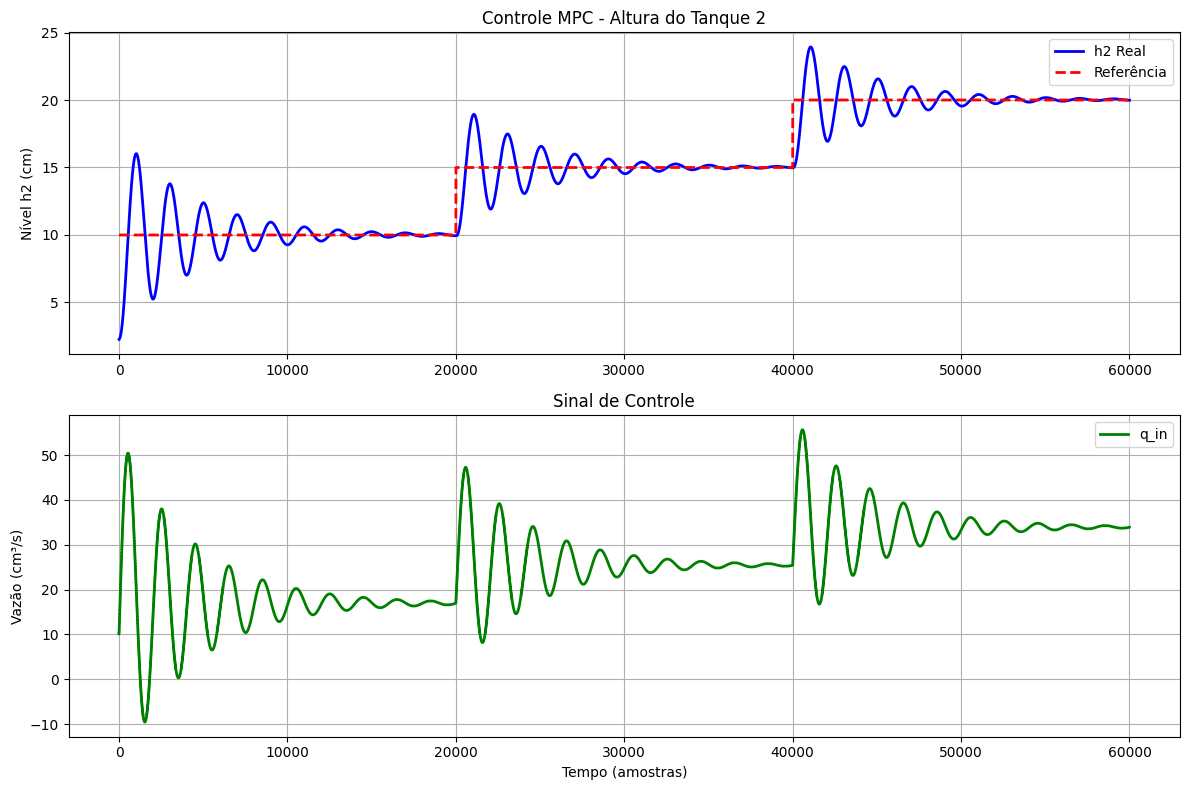

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt

# Inicia a medição de tempo
start_time = time.time()

# =======================
# SIMULAÇÃO (CÓDIGO PRINCIPAL)
# =======================

N_sim = 60000
x_hist = np.zeros((N_sim+1, 2))
u_hist = np.zeros(N_sim)
ref_hist = np.zeros(N_sim+1)

# Condição inicial
x0 = np.array([h1_ss, h2_ss])
x_hist[0, :] = x0

# Controle incremental: inicie com u_prev = q_in (controle absoluto inicial)
u_prev = q_in

# Para simular um degrau variável, definimos o perfil de referência:
# - Para k < N_sim/3, ref = 10;
# - Para N_sim/3 <= k < 2*N_sim/3, ref = 15;
# - Para k >= 2*N_sim/3, ref = 20.
for k in range(N_sim):
    if k < N_sim/3:
        ref_val = 10
    elif k < 2 * N_sim/3:
        ref_val = 15
    else:
        ref_val = 20
    ref_hist[k] = ref_val

    # Atualiza os parâmetros do MPC
    opti.set_value(x_k, x_hist[k, :])
    opti.set_value(Y_ref, ref_val * np.ones(Hp))

    try:
        sol = opti.solve()
        delta_u_opt = sol.value(DeltaU)[0]  # utiliza apenas o primeiro incremento
    except Exception as e:
        print(f"O solver falhou na iteração {k}: {e}")
        delta_u_opt = 0.0  # ou mantenha o último valor válido de delta_u_opt

    # Atualização incremental do controle
    u_new = u_prev + delta_u_opt
    u_hist[k] = u_new

    # Atualização do estado: x[k+1] = A_d * x[k] + B_d * u_new
    x_next = A_d @ x_hist[k, :].reshape(-1, 1) + B_d * u_new
    x_next = x_next.flatten()

    # Aplicar restrição física para h2 (o segundo estado)
    x_next[1] = np.clip(x_next[1], h2_min_allowed, h2_max_lim)

    x_hist[k+1, :] = x_next
    u_prev = u_new

# Preenche o último ponto do perfil de referência
ref_hist[-1] = ref_hist[-2]

# =======================
# FIM DA SIMULAÇÃO
# =======================

# Finaliza a medição de tempo
end_time = time.time()
total_time = end_time - start_time
avg_iter_time = total_time / N_sim

print(f"Tempo total da simulação: {total_time:.3f} segundos")
print(f"Tempo médio por iteração: {avg_iter_time:.6f} segundos")

# Visualização dos Resultados
plt.figure(figsize=(12,8))

# Gráfico do nível de h2 e do set-point
plt.subplot(2,1,1)
plt.plot(x_hist[:, 1], 'b-', linewidth=2, label='h2 Real')
plt.plot(ref_hist, 'r--', linewidth=2, label='Referência')
plt.ylabel('Nível h2 (cm)')
plt.title('Controle MPC - Altura do Tanque 2')
plt.legend()
plt.grid(True)

# Gráfico do sinal de controle (vazão)
plt.subplot(2,1,2)
plt.step(np.arange(N_sim), u_hist, 'g-', linewidth=2, where='post', label='q_in')
plt.ylabel('Vazão (cm³/s)')
plt.xlabel('Tempo (amostras)')
plt.title('Sinal de Controle')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
print(Theta)

NameError: name 'Theta' is not defined

<ipython-input-21-1256eb3e45f7>:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Theta[i, j] = C @ np.linalg.matrix_power(A, i-j) @ B


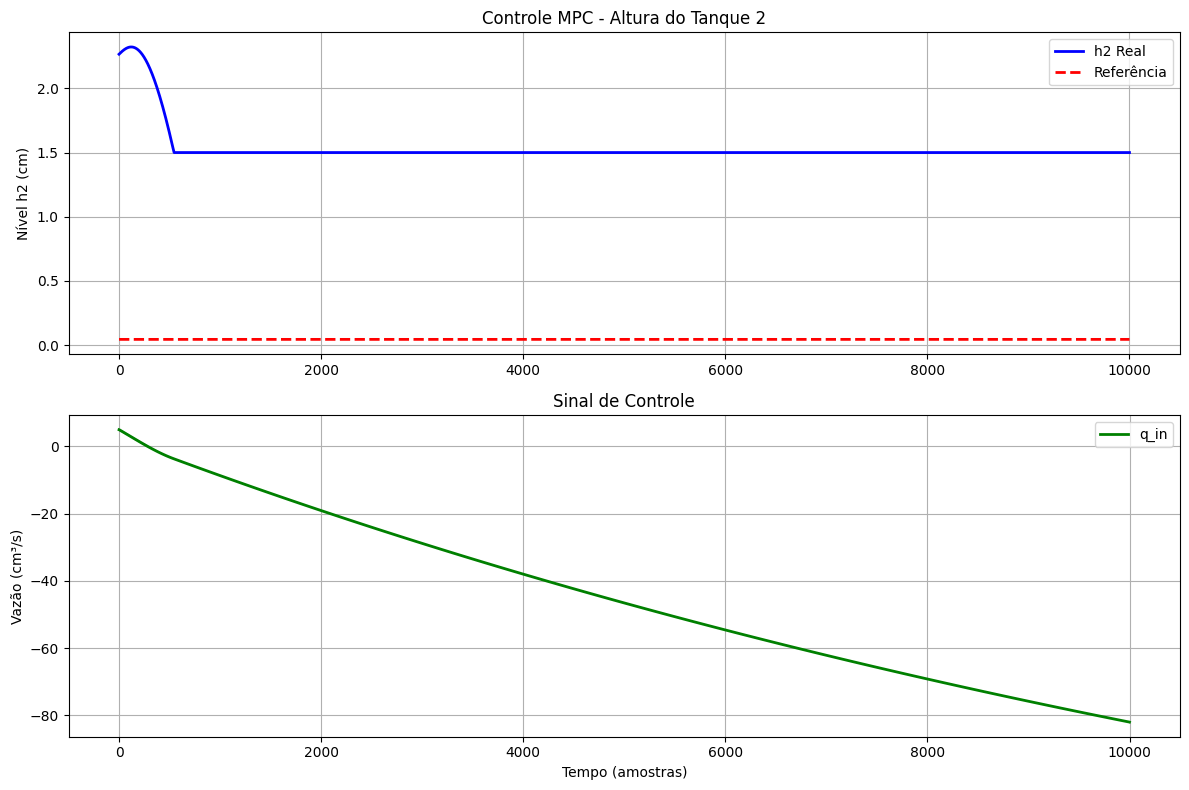

In [ ]:
import numpy as np
import control as ct
import cvxpy as cp
import matplotlib.pyplot as plt

# =======================
# Parâmetros do Sistema
# =======================
alpha1 = 0.56
alpha2 = 0.30
s1 = 0.50       # cm²
s2 = 0.50       # cm²
g = 980.665     # cm/s²
R = 14.85       # cm
q_in = 5       # cm³/s (controle inicial)

# Pontos de equilíbrio (valores do sistema em regime estacionário)
h1_ss = 0.650813
h2_ss = 2.265876

# Definir limites para h2 (altura do tanque 2)
h2_max_allowed = 30      # cm (valor máximo definido)
h2_min_allowed = 0.05 * h2_max_allowed  # 5% do valor máximo
h2_max_lim   = 0.95 * h2_max_allowed      # 95% do valor máximo

# =======================
# Matrizes do Modelo Contínuo
# =======================
A11 = -(alpha1 * s1 * np.sqrt(2*g*h1_ss)) / (2 * h1_ss * np.pi * (2*R*h1_ss - h1_ss**2))
A12 = 0.0
A21 = (alpha1 * s1 * np.sqrt(2*g*h1_ss)) / (np.pi * (2*R*h2_ss - h2_ss**2))
A22 = -(alpha2 * s2 * np.sqrt(2*g*h2_ss)) / (2 * h2_ss * np.pi * (2*R*h2_ss - h2_ss**2))

A = np.array([[A11, A12],
              [A21, A22]], dtype=float)

B11 = 1 / (np.pi * (2*R*h1_ss - h1_ss**2))
B = np.array([[B11],
              [0.0]], dtype=float)

C = np.array([[0, 1]], dtype=float)   # Mede apenas h2
D = np.array([[0.0]])

# Criação do sistema de espaço de estados contínuo
sys_cont = ct.ss(A, B, C, D)
dt = 0.1  # Período de amostragem
sysd = ct.c2d(sys_cont, dt, method='zoh')

A_d = np.array(sysd.A, dtype=float)
B_d = np.array(sysd.B, dtype=float)
C_d = np.array(sysd.C, dtype=float)

# =======================
# Configuração do MPC
# =======================
Hp = 20  # Horizonte de predição
Hc = 3   # Horizonte de controle
Q_val = 10  # Peso do erro de rastreamento (alta penalização para erro em h2)
R_val = 2     # Peso do esforço de controle

# Função para construir as matrizes de predição Phi e Theta
def construir_matrizes_predicao(A, B, C, Hp, Hc):
    n_states = A.shape[0]
    n_inputs = B.shape[1]

    Phi = np.zeros((Hp, n_states))
    Theta = np.zeros((Hp, Hc))

    for i in range(Hp):
        Phi[i, :] = C @ np.linalg.matrix_power(A, i+1)

    for j in range(Hc):
        for i in range(j, Hp):
            Theta[i, j] = C @ np.linalg.matrix_power(A, i-j) @ B
    return Phi, Theta

Phi, Theta = construir_matrizes_predicao(A_d, B_d, C_d, Hp, Hc)

# =======================
# Formulação QP
# =======================
# Matriz Hessiana (H) e vetor linear (f)
Q_bar = Q_val * np.eye(Hp)
R_bar = R_val * np.eye(Hc)

H = 2 * (Theta.T @ Q_bar @ Theta + R_bar)  # Hessiana
H = (H + H.T) / 2  # Garantir simetria

# Variável de decisão: DeltaU (incrementos de controle)
DeltaU = cp.Variable(Hc)

# Parâmetros: estado atual x_k e trajetória de referência Y_ref
x_k = cp.Parameter(2)
Y_ref = cp.Parameter(Hp)

# Resposta livre (sem controle incremental)
Y_free = Phi @ x_k

# Vetor linear (f)
f = 2 * (Y_free - Y_ref).T @ Q_bar @ Theta

# Função de custo
cost = 0.5 * cp.quad_form(DeltaU, H) + f @ DeltaU

# Restrições no controle incremental
constraints = [-10 <= DeltaU, DeltaU <= 10]

# Problema de otimização
problem = cp.Problem(cp.Minimize(cost), constraints)

# =======================
# Simulação
# =======================
N_sim = 10000
x_hist = np.zeros((N_sim+1, 2))
u_hist = np.zeros(N_sim)
ref_hist = np.zeros(N_sim+1)

# Condição inicial
x0 = np.array([h1_ss, h2_ss])
x_hist[0, :] = x0
# Definir o set-point desejado para h2
for k in range(N_sim):
    if k < N_sim/5:
        ref_val = 3
    elif k < 2 * N_sim/2:
        ref_val = 3.5
    else:
        ref_val = 2.8
    ref_hist[k] = ref_val

ref_hist[:] = ref

# Controle incremental: inicie com u_prev = q_in (controle absoluto inicial)
u_prev = q_in

for k in range(N_sim):
    # Atualizar parâmetros: estado atual e referência constante (trajetória de Hp passos iguais)
    x_k.value = x_hist[k, :]
    Y_ref.value = ref * np.ones(Hp)

    try:
        problem.solve(solver=cp.OSQP)
        delta_u_opt = DeltaU.value[0]  # utiliza apenas o primeiro incremento
    except Exception as e:
        print(f"O solver falhou na iteração {k}: {e}")
        delta_u_opt = 0.0

    # Atualização incremental do controle
    u_new = u_prev + delta_u_opt
    u_hist[k] = u_new

    # Atualização do estado: x[k+1] = A_d * x[k] + B_d * u_new
    x_next = A_d @ x_hist[k, :].reshape(-1, 1) + B_d * u_new
    x_next = x_next.flatten()

    # Aplicar restrição física para h2 (o segundo estado)
    x_next[1] = np.clip(x_next[1], h2_min_allowed, h2_max_lim)

    x_hist[k+1, :] = x_next
    u_prev = u_new

# =======================
# Visualização dos Resultados
# =======================
plt.figure(figsize=(12,8))

# Gráfico do nível de h2 e do set-point
plt.subplot(2,1,1)
plt.plot(x_hist[:, 1], 'b-', linewidth=2, label='h2 Real')
plt.plot(ref_hist, 'r--', linewidth=2, label='Referência')
plt.ylabel('Nível h2 (cm)')
plt.title('Controle MPC - Altura do Tanque 2')
plt.legend()
plt.grid(True)

# Gráfico do sinal de controle (vazão)
plt.subplot(2,1,2)
plt.step(np.arange(N_sim), u_hist, 'g-', linewidth=2, where='post', label='q_in')
plt.ylabel('Vazão (cm³/s)')
plt.xlabel('Tempo (amostras)')
plt.title('Sinal de Controle')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**Mais Correto**

<ipython-input-18-6440d9ff614e>:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Theta[i, j] = C @ np.linalg.matrix_power(A, i-j) @ B


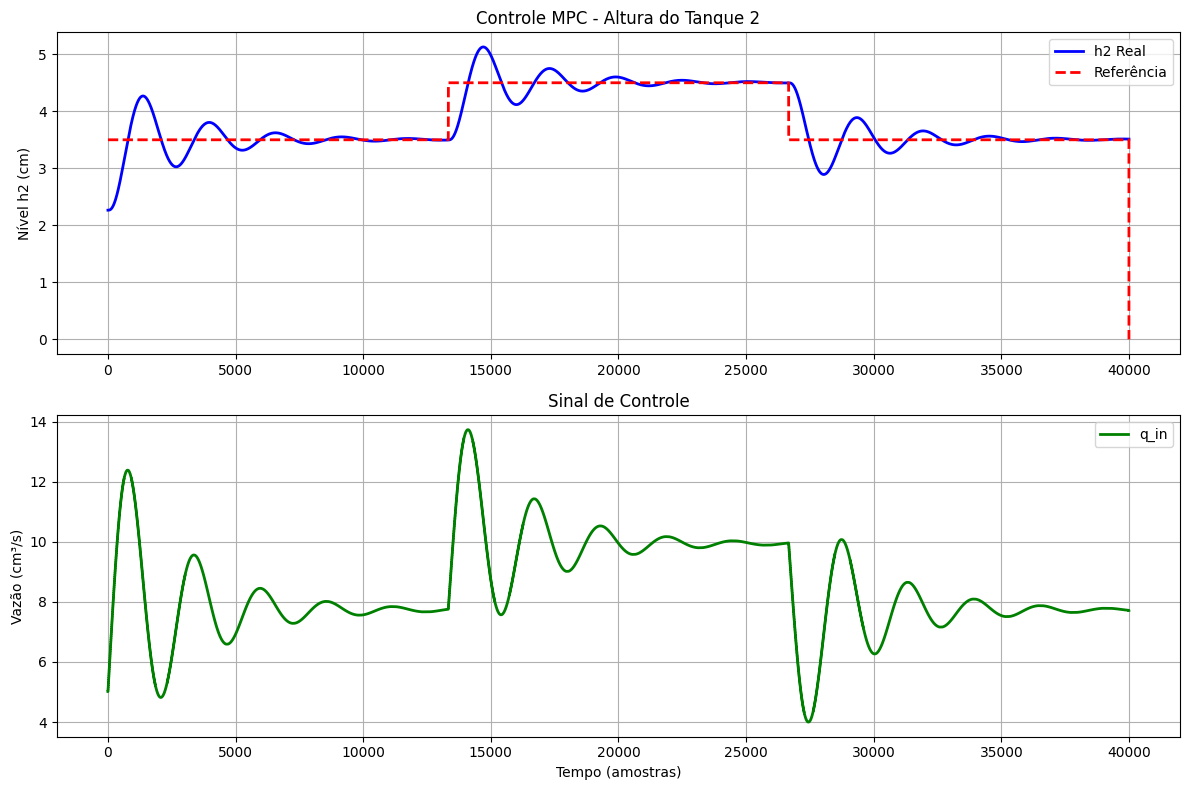

In [ ]:
import numpy as np
import control as ct
import cvxpy as cp
import matplotlib.pyplot as plt

# =======================
# Parâmetros do Sistema
# =======================
alpha1 = 0.56
alpha2 = 0.30
s1 = 0.50       # cm²
s2 = 0.50       # cm²
g = 980.665     # cm/s²
R = 14.85       # cm
q_in = 5       # cm³/s (controle inicial)

# Pontos de equilíbrio (valores do sistema em regime estacionário)
h1_ss = 0.650813
h2_ss = 2.265876

# Definir limites para h2 (altura do tanque 2)
h2_max_allowed = 28      # cm (valor máximo definido)
h2_min_allowed = 0.05 * h2_max_allowed  # 5% do valor máximo
h2_max_lim   = 0.95 * h2_max_allowed      # 95% do valor máximo

# =======================
# Matrizes do Modelo Contínuo
# =======================
A11 = -0.12930622
A12 = 0.0
A21 = 0.03935484
A22 = -0.01130748

A = np.array([[A11, A12],
              [A21, A22]], dtype=float)

B11 = 0.01683681
B = np.array([[B11],
              [0.0]], dtype=float)

C = np.array([[0, 1]], dtype=float)   # Mede apenas h2
D = np.array([[0.0]])

# Criação do sistema de espaço de estados contínuo
sys_cont = ct.ss(A, B, C, D)
dt = 0.1  # Período de amostragem
sysd = ct.c2d(sys_cont, dt, method='zoh')

A_d = np.array(sysd.A, dtype=float)
B_d = np.array(sysd.B, dtype=float)
C_d = np.array(sysd.C, dtype=float)

# =======================
# Configuração do MPC
# =======================
Hp = 20  # Horizonte de predição
Hc = 3   # Horizonte de controle
Q_val = 1000  # Peso do erro de rastreamento (alta penalização para erro em h2)
R_val = 100     # Peso do esforço de controle

# Função para construir as matrizes de predição Phi e Theta
def construir_matrizes_predicao(A, B, C, Hp, Hc):
    n_states = A.shape[0]
    n_inputs = B.shape[1]

    Phi = np.zeros((Hp, n_states))
    Theta = np.zeros((Hp, Hc))

    for i in range(Hp):
        Phi[i, :] = C @ np.linalg.matrix_power(A, i+1)

    for j in range(Hc):
        for i in range(j, Hp):
            Theta[i, j] = C @ np.linalg.matrix_power(A, i-j) @ B
    return Phi, Theta

Phi, Theta = construir_matrizes_predicao(A_d, B_d, C_d, Hp, Hc)

# =======================
# Formulação QP
# =======================
# Matriz Hessiana (H) e vetor linear (f)
Q_bar = Q_val * np.eye(Hp)
R_bar = R_val * np.eye(Hc)

H = 2 * (Theta.T @ Q_bar @ Theta + R_bar)  # Hessiana
H = (H + H.T) / 2  # Garantir simetria

# Variável de decisão: DeltaU (incrementos de controle)
DeltaU = cp.Variable(Hc)

# Parâmetros: estado atual x_k e trajetória de referência Y_ref
x_k = cp.Parameter(2)
Y_ref = cp.Parameter(Hp)

# Problema de otimização
problem = cp.Problem(cp.Minimize(0), [])  # Placeholder, será atualizado a cada iteração

# =======================
# Simulação
# =======================
N_sim = 40000
x_hist = np.zeros((N_sim+1, 2))
u_hist = np.zeros(N_sim)
ref_hist = np.zeros(N_sim+1)

# Condição inicial
x0 = np.array([h1_ss, h2_ss])
x_hist[0, :] = x0

# Definir o set-point desejado para h2
for k in range(N_sim):
    if k < N_sim/3:
        ref_val = 3.5
    elif k < 2 * N_sim/3:
        ref_val = 4.5
    elif k < 3 * N_sim/3:
        ref_val = 3.5

    ref_hist[k] = ref_val

# Controle incremental: inicie com u_prev = q_in (controle absoluto inicial)
u_prev = q_in

for k in range(N_sim):
    # Atualizar parâmetros: estado atual e referência constante (trajetória de Hp passos iguais)
    x_k.value = x_hist[k, :]
    Y_ref.value = ref_hist[k] * np.ones(Hp)

    # Resposta livre (sem controle incremental)
    Y_free = Phi @ x_k.value

    # Vetor linear (f)
    f = 2 * (Y_free - Y_ref.value).T @ Q_bar @ Theta

    # Função de custo
    cost = 0.5 * cp.quad_form(DeltaU, H) + f @ DeltaU

    # Restrições no controle incremental
    constraints = [-10 <= DeltaU, DeltaU <= 10]

    # Atualizar o problema de otimização
    problem = cp.Problem(cp.Minimize(cost), constraints)

    try:
        problem.solve(solver=cp.OSQP)
        delta_u_opt = DeltaU.value[0]  # utiliza apenas o primeiro incremento
    except Exception as e:
        print(f"O solver falhou na iteração {k}: {e}")
        delta_u_opt = 0.0

    # Atualização incremental do controle
    u_new = u_prev + delta_u_opt
    u_hist[k] = u_new

    # Atualização do estado: x[k+1] = A_d * x[k] + B_d * u_new
    x_next = A_d @ x_hist[k, :].reshape(-1, 1) + B_d * u_new
    x_next = x_next.flatten()

    # Aplicar restrição física para h2 (o segundo estado)
    x_next[1] = np.clip(x_next[1], h2_min_allowed, h2_max_lim)

    x_hist[k+1, :] = x_next
    u_prev = u_new

# =======================
# Visualização dos Resultados
# =======================
plt.figure(figsize=(12,8))

# Gráfico do nível de h2 e do set-point
plt.subplot(2,1,1)
plt.plot(x_hist[:, 1], 'b-', linewidth=2, label='h2 Real')
plt.plot(ref_hist, 'r--', linewidth=2, label='Referência')
plt.ylabel('Nível h2 (cm)')
plt.title('Controle MPC - Altura do Tanque 2')
plt.legend()
plt.grid(True)

# Gráfico do sinal de controle (vazão)
plt.subplot(2,1,2)
plt.step(np.arange(N_sim), u_hist, 'g-', linewidth=2, where='post', label='q_in')
plt.ylabel('Vazão (cm³/s)')
plt.xlabel('Tempo (amostras)')
plt.title('Sinal de Controle')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Tentativa com PSO

In [ ]:
!pip install pyswarms
!pip install control

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.6/549.6 kB 12.5 MB/s eta 0:00:00


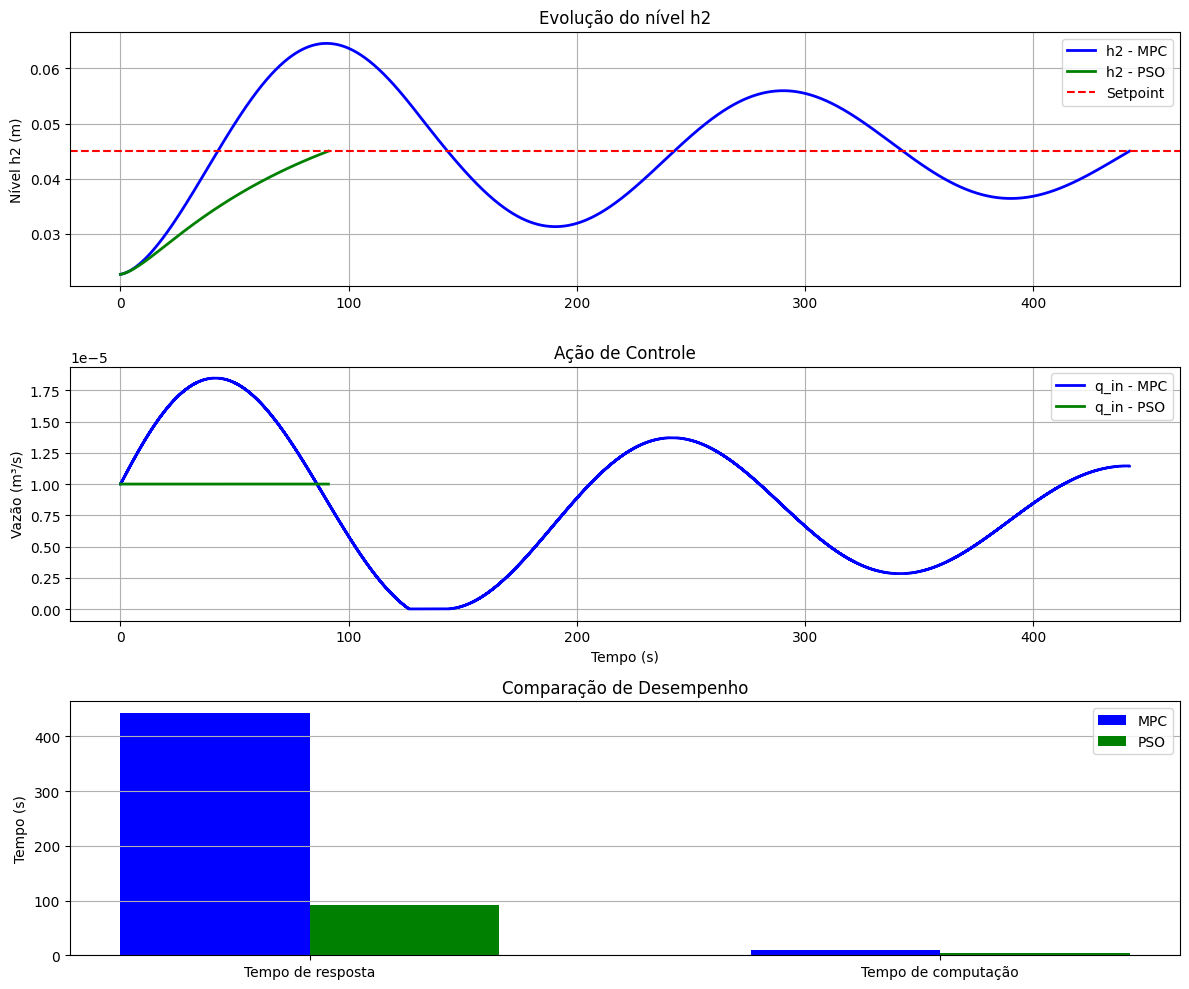

In [ ]:
import numpy as np
import control as ct
import cvxpy as cp
import matplotlib.pyplot as plt
import pyswarms as ps
import time

# =============================================================================
# Parâmetros do Sistema (valores originais em cm, cm³/s)
# =============================================================================
alpha1 = 0.56
alpha2 = 0.30
s1 = 0.50       # cm²
s2 = 0.50       # cm²
g = 980.665     # cm/s²
R = 14.85       # cm
q_in = 10        # cm³/s (controle inicial)

# Pontos de equilíbrio (em cm)
h1_ss = 0.650813
h2_ss = 2.265876

# Limites para h2 (em cm)
h2_max_allowed = 28
h2_min_allowed = 0.05 * h2_max_allowed
h2_max_lim   = 0.95 * h2_max_allowed

# =============================================================================
# Modelo Contínuo e Discretização
# =============================================================================
A11 = -(alpha1 * s1 * np.sqrt(2*g*h1_ss)) / (2 * h1_ss * np.pi * (2*R*h1_ss - h1_ss**2))
A12 = 0.0
A21 = (alpha1 * s1 * np.sqrt(2*g*h1_ss)) / (np.pi * (2*R*h2_ss - h2_ss**2))
A22 = -(alpha2 * s2 * np.sqrt(2*g*h2_ss)) / (2 * h2_ss * np.pi * (2*R*h2_ss - h2_ss**2))

A = np.array([[A11, A12],
              [A21, A22]], dtype=float)

B11 = 1 / (np.pi * (2*R*h1_ss - h1_ss**2))
B = np.array([[B11],
              [0.0]], dtype=float)

C = np.array([[0, 1]], dtype=float)  # mede apenas h2
D = np.array([[0.0]])

sys_cont = ct.ss(A, B, C, D)
dt = 0.1  # intervalo de amostragem (s)
sysd = ct.c2d(sys_cont, dt, method='zoh')
A_d = np.array(sysd.A, dtype=float)
B_d = np.array(sysd.B, dtype=float)
C_d = np.array(sysd.C, dtype=float)

# =============================================================================
# Configurações Gerais de Simulação
# =============================================================================
max_iter = 10000    # Máximo de iterações
tol = 1e-3         # Tolerância para atingir o setpoint
ref = 4.5          # Setpoint para h2 (em cm)
u_min, u_max = 0, 20  # Limites para vazão (cm³/s)

# =============================================================================
# 1) Controle via MPC (QP)
# =============================================================================
Q_val = 100   # Penalização do erro
R_val = 10    # Penalização do esforço
Hp = 20       # Horizonte de previsão
Hc = 3        # Horizonte de controle

n_states = A_d.shape[0]
n_outputs = C_d.shape[0]

# Construção das matrizes de predição
Phi = np.zeros((Hp, n_states))
Theta = np.zeros((Hp, Hc))
for i in range(Hp):
    A_pow = np.linalg.matrix_power(A_d, i+1)
    Phi[i, :] = (C_d @ A_pow).flatten()
    for j in range(Hc):
        if i - j >= 0:
            A_term = np.linalg.matrix_power(A_d, i - j) if (i - j) > 0 else np.eye(n_states)
            Theta[i, j] = (C_d @ (A_term @ B_d))[0, 0]

# Matriz de penalização do erro e construção da Hessiana do QP
Q_m = Q_val * np.eye(Hp)
H_mpc = 2 * (Theta.T @ Q_m @ Theta + R_val * np.eye(Hc))
H_mpc = 0.5 * (H_mpc + H_mpc.T)  # Garantir simetria

# Definição do problema QP
DeltaU = cp.Variable(Hc)
f_param = cp.Parameter(Hc)
cost_expr = 0.5 * cp.quad_form(DeltaU, H_mpc) + f_param.T @ DeltaU
constraints = [DeltaU >= -10, DeltaU <= 10]
prob = cp.Problem(cp.Minimize(cost_expr), constraints)

# Variáveis de simulação para MPC
x_hist_mpc = []
u_hist_mpc = []
x_current = np.array([h1_ss, h2_ss])
u_prev = q_in
k_mpc = 0
start_time_mpc = time.time()

while k_mpc < max_iter:
    x_hist_mpc.append(x_current.copy())
    u_hist_mpc.append(u_prev)

    # Atualiza o termo linear do QP
    f_param.value = 2 * Theta.T @ Q_m @ (Phi @ x_current - np.ones(Hp)*ref)
    prob.solve(solver=cp.OSQP, warm_start=True, verbose=False)

    # Se não obteve solução, zera o incremento
    if DeltaU.value is None:
        delta_u_opt = 0.0
    else:
        delta_u_opt = DeltaU.value[0]

    # Atualiza a ação de controle e aplica saturação
    u_new = np.clip(u_prev + delta_u_opt, u_min, u_max)

    # Evolução do sistema
    x_next = A_d @ x_current.reshape(-1, 1) + B_d * u_new
    x_next = x_next.flatten()
    x_next[1] = np.clip(x_next[1], h2_min_allowed, h2_max_lim)

    # Verifica se atingiu o setpoint
    if abs(x_next[1] - ref) < tol:
        x_hist_mpc.append(x_next.copy())
        u_hist_mpc.append(u_new)
        break

    x_current = x_next
    u_prev = u_new
    k_mpc += 1

end_time_mpc = time.time()
time_mpc = end_time_mpc - start_time_mpc

x_hist_mpc = np.array(x_hist_mpc)
u_hist_mpc = np.array(u_hist_mpc)

# =============================================================================
# 2) Controle via PSO
# =============================================================================
def pso_objective(u_candidates, x_init, ref, u_prev=0):
    """
    Função objetivo para PSO.

    Avalia o custo de cada candidato de controle considerando a evolução
    do sistema. O custo é definido como a soma do erro quadrático entre
    a segunda variável de estado (h2) e o setpoint, acrescido de uma penalização
    para variação brusca no controle (diferença em relação a u_prev).

    Parâmetros:
        u_candidates (np.ndarray): Array de candidatos (n_particles, n_dims).
                                   Espera-se que o controle esteja na 1ª coluna.
        x_init (np.ndarray): Estado inicial atual.
        ref (float): Setpoint para h2.
        u_prev (float, opcional): Valor anterior do controle. Default é 0.

    Retorna:
        np.ndarray: Array de custos para cada partícula.
    """
    # Aplica saturação nos candidatos de controle (utilizando a 1ª dimensão)
    u = np.clip(u_candidates[:, 0], u_min, u_max)  # shape: (n_particles,)

    # Calcula a parte constante da dinâmica: A_d @ x_init
    x_const = (A_d @ x_init.reshape(-1, 1)).flatten()  # shape: (n_states,)

    # Calcula o estado seguinte para cada candidato:
    # x_next = A_d * x_init + B_d * u
    # Utiliza broadcasting para aplicar B_d a cada candidato de controle
    x_next = x_const + u[:, np.newaxis] * B_d.flatten()  # shape: (n_particles, n_states)

    # Aplica saturação à segunda variável de estado (h2)
    x_next[:, 1] = np.clip(x_next[:, 1], h2_min_allowed, h2_max_lim)

    # Calcula o custo: erro quadrático + penalização pela variação no controle
    costs = (x_next[:, 1] - ref)**2 + 0.1 * (u - u_prev)**2

    return costs

# Configurações do PSO
options = {'c1': 0.3, 'c2': 0.2, 'w': 0.7}
bounds = (np.array([u_min]), np.array([u_max]))
optimizer = ps.single.GlobalBestPSO(n_particles=500, dimensions=1, options=options, bounds=bounds)

x_hist_pso = []
u_hist_pso = []
x_current_pso = np.array([h1_ss, h2_ss])
u_prev_pso = q_in
k_pso = 0
start_time_pso = time.time()

while k_pso < max_iter:
    x_hist_pso.append(x_current_pso.copy())
    u_hist_pso.append(u_prev_pso)

    # Note que passamos o parâmetro u_prev explicitamente
    best_cost, best_pos = optimizer.optimize(
        pso_objective,
        iters=15,
        verbose=False,
        x_init=x_current_pso,
        ref=ref,
        u_prev=u_prev_pso
    )
    u_best = np.clip(best_pos[0], u_min, u_max)

    # Evolução do sistema para o PSO
    x_next = A_d @ x_current_pso.reshape(-1, 1) + B_d * u_best
    x_next = x_next.flatten()
    x_next[1] = np.clip(x_next[1], h2_min_allowed, h2_max_lim)

    if abs(x_next[1] - ref) < tol:
        x_hist_pso.append(x_next.copy())
        u_hist_pso.append(u_best)
        break

    x_current_pso = x_next
    u_prev_pso = u_best
    k_pso += 1

end_time_pso = time.time()
time_pso = end_time_pso - start_time_pso

x_hist_pso = np.array(x_hist_pso)
u_hist_pso = np.array(u_hist_pso)

# =============================================================================
# Conversão para Unidades SI
# =============================================================================
# 1 cm = 0.01 m, 1 cm³/s = 1e-6 m³/s
x_hist_mpc_SI = x_hist_mpc * 0.01      # converte níveis de cm para m
x_hist_pso_SI = x_hist_pso * 0.01
u_hist_mpc_SI = u_hist_mpc * 1e-6       # converte vazões de cm³/s para m³/s
u_hist_pso_SI = u_hist_pso * 1e-6
ref_SI = ref * 0.01

tempo_mpc = np.arange(len(x_hist_mpc_SI)) * dt
tempo_pso = np.arange(len(x_hist_pso_SI)) * dt

# =============================================================================
# Gráficos Comparativos
# =============================================================================
plt.figure(figsize=(12, 10))

# Gráfico 1: Evolução do nível h2
plt.subplot(3, 1, 1)
plt.plot(tempo_mpc, x_hist_mpc_SI[:, 1], 'b-', linewidth=2, label='h2 - MPC')
plt.plot(tempo_pso, x_hist_pso_SI[:, 1], 'g-', linewidth=2, label='h2 - PSO')
plt.axhline(ref_SI, color='r', linestyle='--', label='Setpoint')
plt.ylabel('Nível h2 (m)')
plt.title('Evolução do nível h2')
plt.legend()
plt.grid(True)

# Gráfico 2: Ação de controle (vazão)
plt.subplot(3, 1, 2)
plt.step(tempo_mpc, u_hist_mpc_SI, 'b-', linewidth=2, where='post', label='q_in - MPC')
plt.step(tempo_pso, u_hist_pso_SI, 'g-', linewidth=2, where='post', label='q_in - PSO')
plt.ylabel('Vazão (m³/s)')
plt.xlabel('Tempo (s)')
plt.title('Ação de Controle')
plt.legend()
plt.grid(True)

# Gráfico 3: Comparação dos tempos de resposta e de computação
plt.subplot(3, 1, 3)
bars = ['Tempo de resposta', 'Tempo de computação']
mpc_vals = [tempo_mpc[-1], time_mpc]
pso_vals = [tempo_pso[-1], time_pso]
x_pos = np.arange(len(bars))
width = 0.3

plt.bar(x_pos - width/2, mpc_vals, width, label='MPC', color='blue')
plt.bar(x_pos + width/2, pso_vals, width, label='PSO', color='green')
plt.xticks(x_pos, bars)
plt.ylabel('Tempo (s)')
plt.title('Comparação de Desempenho')
plt.legend()
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()


2025-02-12 15:37:48,969 - pyswarms.single.global_best - INFO - Optimize for 3 iters with {'c1': 0.8, 'c2': 0.5, 'w': 0.6}
pyswarms.single.global_best: 100%|██████████|3/3, best_cost=4.99e+4
2025-02-12 15:37:48,989 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 49877.870982358676, best pos: [9.94908396]
2025-02-12 15:37:48,992 - pyswarms.single.global_best - INFO - Optimize for 3 iters with {'c1': 0.8, 'c2': 0.5, 'w': 0.6}
pyswarms.single.global_best: 100%|██████████|3/3, best_cost=4.98e+4
2025-02-12 15:37:49,010 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 49840.296122970634, best pos: [9.94877878]
2025-02-12 15:37:49,013 - pyswarms.single.global_best - INFO - Optimize for 3 iters with {'c1': 0.8, 'c2': 0.5, 'w': 0.6}
pyswarms.single.global_best: 100%|██████████|3/3, best_cost=4.98e+4
2025-02-12 15:37:49,026 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 49801.18330408848, best pos: [9.94594204]
2025-02-

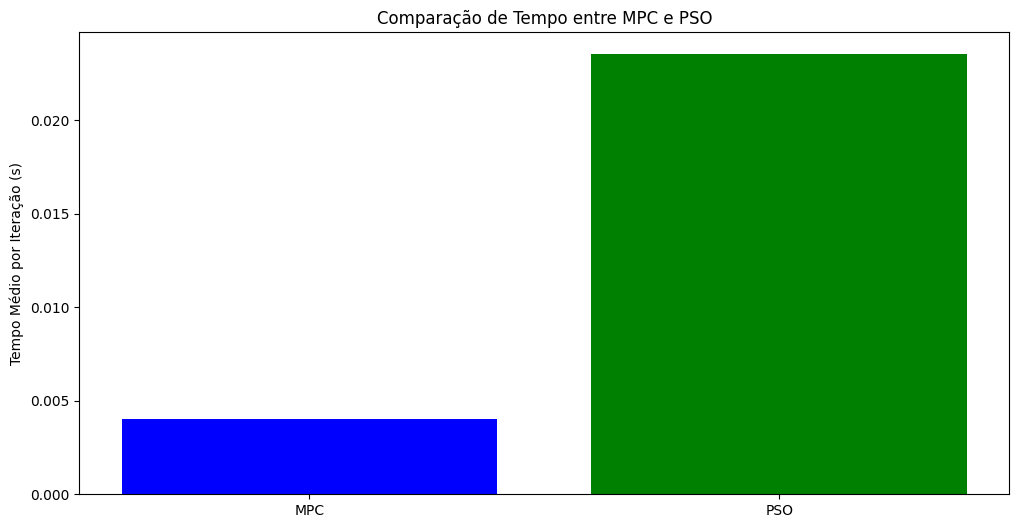

In [ ]:
import numpy as np
import control as ct
import cvxpy as cp
import matplotlib.pyplot as plt
import pyswarms as ps
import time

# =============================================================================
# Parâmetros do Sistema
# =============================================================================
alpha1 = 0.56
alpha2 = 0.30
s1 = 0.50  # cm²
s2 = 0.50  # cm²
g = 980.665  # cm/s²
R = 14.85  # cm
q_in = 10  # cm³/s

# Pontos de equilíbrio (cm)
h1_ss = 0.650813
h2_ss = 2.265876

# Limites para h2 (cm)
h2_max_allowed = 28
h2_min_allowed = 0.05 * h2_max_allowed
h2_max_lim = 0.95 * h2_max_allowed

# =============================================================================
# Modelo Contínuo e Discretização
# =============================================================================
A11 = -(alpha1 * s1 * np.sqrt(2*g*h1_ss)) / (2 * h1_ss * np.pi * (2*R*h1_ss - h1_ss**2))
A12 = 0.0
A21 = (alpha1 * s1 * np.sqrt(2*g*h1_ss)) / (np.pi * (2*R*h2_ss - h2_ss**2))
A22 = -(alpha2 * s2 * np.sqrt(2*g*h2_ss)) / (2 * h2_ss * np.pi * (2*R*h2_ss - h2_ss**2))

A = np.array([[A11, A12], [A21, A22]], dtype=float)
B11 = 1 / (np.pi * (2*R*h1_ss - h1_ss**2))
B = np.array([[B11], [0.0]], dtype=float)
C = np.array([[0, 1]], dtype=float)
D = np.array([[0.0]])

sys_cont = ct.ss(A, B, C, D)
dt = 0.1  # intervalo de amostragem (s)
sysd = ct.c2d(sys_cont, dt, method='zoh')
A_d = np.array(sysd.A, dtype=float)
B_d = np.array(sysd.B, dtype=float)
C_d = np.array(sysd.C, dtype=float)

# =============================================================================
# Configurações Gerais de Simulação
# =============================================================================
max_iter = 1000  # Máximo de iterações
tol = 1e-3  # Tolerância
ref = 4.5  # Setpoint (cm)
u_min, u_max = 0, 20  # Limites de vazão (cm³/s)

# =============================================================================
# Controle MPC (QP)
# =============================================================================
Q_val, R_val = 100, 10
Hp, Hc = 20, 3  # Horizontes
n_states, n_outputs = A_d.shape[0], C_d.shape[0]

Phi = np.zeros((Hp, n_states))
Theta = np.zeros((Hp, Hc))
for i in range(Hp):
    Phi[i, :] = (C_d @ np.linalg.matrix_power(A_d, i+1)).flatten()
    for j in range(Hc):
        if i - j >= 0:
            A_term = np.linalg.matrix_power(A_d, i - j) if (i - j) > 0 else np.eye(n_states)
            Theta[i, j] = (C_d @ (A_term @ B_d))[0, 0]

Q_m = Q_val * np.eye(Hp)
H_mpc = 2 * (Theta.T @ Q_m @ Theta + R_val * np.eye(Hc))
H_mpc = 0.5 * (H_mpc + H_mpc.T)

DeltaU = cp.Variable(Hc)
f_param = cp.Parameter(Hc)
cost_expr = 0.5 * cp.quad_form(DeltaU, H_mpc) + f_param.T @ DeltaU
constraints = [DeltaU >= -20, DeltaU <= 20]
prob = cp.Problem(cp.Minimize(cost_expr), constraints)

x_hist_mpc, u_hist_mpc = [], []
x_current, u_prev = np.array([h1_ss, h2_ss]), q_in
start_time_mpc = time.time()
for k_mpc in range(max_iter):
    x_hist_mpc.append(x_current.copy())
    u_hist_mpc.append(u_prev)
    f_param.value = 2 * Theta.T @ Q_m @ (Phi @ x_current - np.ones(Hp) * ref)
    prob.solve(solver=cp.OSQP, warm_start=True)
    delta_u_opt = DeltaU.value[0] if DeltaU.value is not None else 0.0
    u_new = np.clip(u_prev + delta_u_opt, u_min, u_max)
    x_current = A_d @ x_current + B_d.flatten() * u_new
    x_current[1] = np.clip(x_current[1], h2_min_allowed, h2_max_lim)
    if abs(x_current[1] - ref) < tol:
        break
    u_prev = u_new

end_time_mpc = time.time()
time_mpc = (end_time_mpc - start_time_mpc) / k_mpc

# =============================================================================
# Controle PSO
# =============================================================================
def pso_objective(u_candidates, x_init, ref, u_prev=0):
    u = np.clip(u_candidates[:, 0], u_min, u_max)
    x_next = (A_d @ x_init).reshape(1, -1) + u[:, np.newaxis] * B_d.T
    x_next[:, 1] = np.clip(x_next[:, 1], h2_min_allowed, h2_max_lim)
    return 1e4 * (x_next[:, 1] - ref) ** 2 + 1e2 * (u - u_prev) ** 2

options = {'c1': 0.8, 'c2': 0.5, 'w': 0.6}
bounds = (np.array([u_min]), np.array([u_max]))
optimizer = ps.single.GlobalBestPSO(n_particles=30, dimensions=1, options=options, bounds=bounds)

x_hist_pso, u_hist_pso = [np.array([h1_ss, h2_ss])], [q_in]
k_pso = 0
start_time_pso = time.time()
while k_pso < max_iter:
    best_cost, best_pos = optimizer.optimize(pso_objective, iters=3, x_init=x_hist_pso[-1], ref=ref, u_prev=u_hist_pso[-1])
    u_best = np.clip(best_pos[0], u_min, u_max)
    x_next = A_d @ x_hist_pso[-1] + B_d.flatten() * u_best
    x_next[1] = np.clip(x_next[1], h2_min_allowed, h2_max_lim)
    if abs(x_next[1] - ref) < tol:
        break
    x_hist_pso.append(x_next)
    u_hist_pso.append(u_best)
    k_pso += 1
end_time_pso = time.time()
time_pso = (end_time_pso - start_time_pso) / k_pso

# =============================================================================
# Comparação de Gráficos e Tempos
# =============================================================================
plt.figure(figsize=(12, 6))
plt.bar(['MPC', 'PSO'], [time_mpc, time_pso], color=['blue', 'green'])
plt.ylabel('Tempo Médio por Iteração (s)')
plt.title('Comparação de Tempo entre MPC e PSO')
plt.show()


2025-02-12 16:31:12,788 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 0.7, 'c2': 0.4, 'w': 0.6}
pyswarms.single.global_best: 100%|██████████|5/5, best_cost=24.8
2025-02-12 16:31:12,808 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 24.84049109068841, best pos: [1.97723565e-05]
2025-02-12 16:31:12,811 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 0.7, 'c2': 0.4, 'w': 0.6}
pyswarms.single.global_best: 100%|██████████|5/5, best_cost=24.7
2025-02-12 16:31:12,832 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 24.726010952637655, best pos: [1.99282166e-05]
2025-02-12 16:31:12,834 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 0.7, 'c2': 0.4, 'w': 0.6}
pyswarms.single.global_best: 100%|██████████|5/5, best_cost=24.6
2025-02-12 16:31:12,848 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 24.613093058497522, best pos: [1.97989286e-05]
2025-

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (2,) and arg 1 with shape (2, 501).

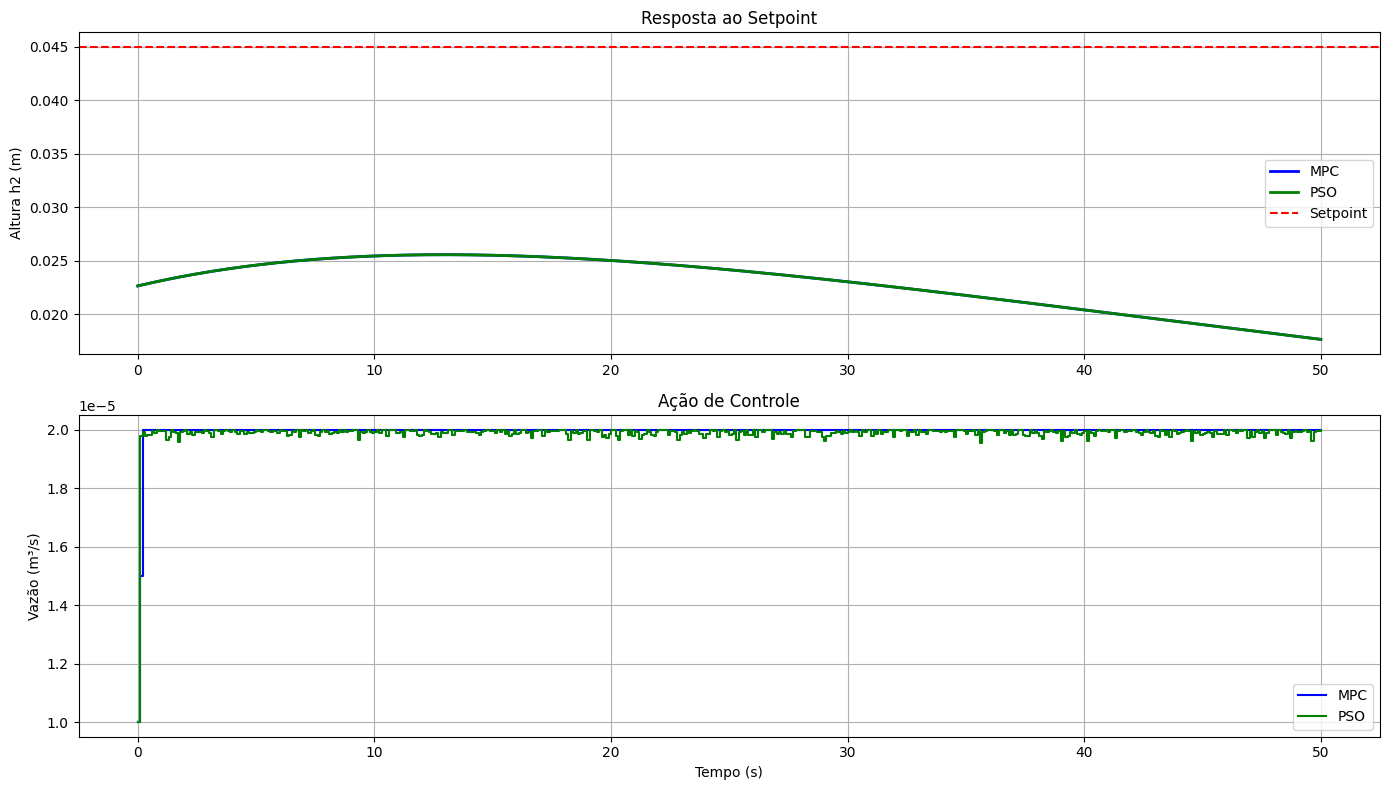

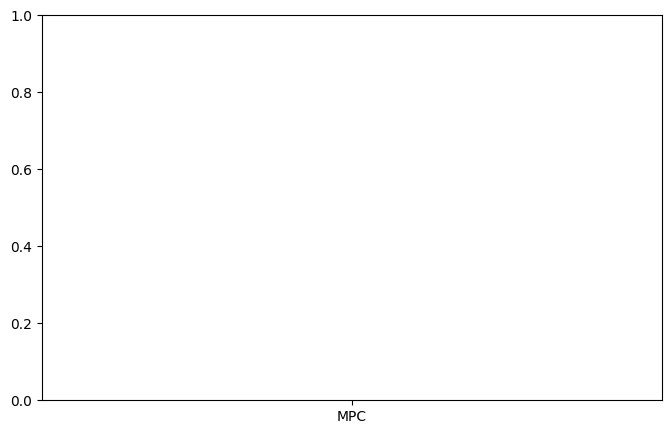

In [ ]:
import numpy as np
import control as ct
import cvxpy as cp
import matplotlib.pyplot as plt
import pyswarms as ps
import time

# =============================================================================
# Parâmetros do Sistema (convertidos para SI)
# =============================================================================
alpha1 = 0.56
alpha2 = 0.30
s1 = 0.50e-4  # m²
s2 = 0.50e-4  # m²
g = 9.80665    # m/s²
R = 0.1485     # m
q_in = 1e-5    # m³/s

# Pontos de equilíbrio (m)
h1_ss = 0.00650813
h2_ss = 0.02265876

# Limites para h2 (m)
h2_max_allowed = 0.28
h2_min_allowed = 0.05 * h2_max_allowed
h2_max_lim = 0.95 * h2_max_allowed

# =============================================================================
# Modelo Linearizado
# =============================================================================
A = np.array([[-0.05, 0.0],
              [0.15, -0.02]])
B = np.array([[0.02],
              [0.0]])
C = np.array([[0, 1]])
D = np.array([[0.0]])

# Discretização
dt = 0.1  # intervalo de amostragem
sys_cont = ct.ss(A, B, C, D)
sysd = ct.c2d(sys_cont, dt, method='zoh')
A_d = np.array(sysd.A)
B_d = np.array(sysd.B)
C_d = np.array(sysd.C)

# =============================================================================
# Configurações de Controle
# =============================================================================
max_iter = 500
tol = 1e-3
ref = 0.045  # Setpoint
u_min, u_max = 0, 2e-5  # m³/s

# =============================================================================
# 1. Controlador MPC (QP)
# =============================================================================
Q_val, R_val = 500, 1
Hp, Hc = 10, 2

# Matrizes de predição
A_pows = [np.linalg.matrix_power(A_d, i+1) for i in range(Hp)]
Phi = np.array([C_d @ A_pow for A_pow in A_pows]).squeeze()

Theta = np.zeros((Hp, Hc))
for i in range(Hp):
    for j in range(Hc):
        if i >= j:
            Theta[i,j] = (C_d @ np.linalg.matrix_power(A_d, i-j) @ B_d)[0,0]

Q_m = Q_val * np.eye(Hp)
H_mpc = 2 * (Theta.T @ Q_m @ Theta + R_val * np.eye(Hc))
H_mpc = (H_mpc + H_mpc.T) / 2

# Problema de otimização
DeltaU = cp.Variable(Hc)
f_param = cp.Parameter(Hc)
prob = cp.Problem(cp.Minimize(0.5 * cp.quad_form(DeltaU, H_mpc) + f_param.T @ DeltaU),
                 [DeltaU >= -5e-6, DeltaU <= 5e-6])

# Simulação MPC
x_mpc = [np.array([h1_ss, h2_ss])]
u_mpc = [q_in]
k_mpc = 0
t_mpc_start = time.time()

while k_mpc < max_iter and abs(x_mpc[-1][1] - ref) > tol:
    f_param.value = 2 * Theta.T @ Q_m @ (Phi @ x_mpc[-1] - ref*np.ones(Hp))
    prob.solve(solver=cp.OSQP, warm_start=True)

    du = DeltaU.value[0] if DeltaU.value is not None else 0
    u_new = np.clip(u_mpc[-1] + du, u_min, u_max)

    x_next = A_d @ x_mpc[-1] + B_d.flatten() * u_new
    x_next[1] = np.clip(x_next[1], h2_min_allowed, h2_max_lim)

    x_mpc.append(x_next)
    u_mpc.append(u_new)
    k_mpc += 1

t_mpc = time.time() - t_mpc_start

# =============================================================================
# 2. Controlador PSO
# =============================================================================
def pso_obj(u_particles, x_current, ref, u_prev):
    u = np.clip(u_particles[:,0], u_min, u_max)
    x_next = (A_d @ x_current) + u[:,None] * B_d.T
    x_next[:,1] = np.clip(x_next[:,1], h2_min_allowed, h2_max_lim)
    return 5e4*(x_next[:,1] - ref)**2 + 1e3*(u - u_prev)**2

# Configuração PSO
options = {'c1': 0.7, 'c2': 0.4, 'w': 0.6}
bounds = (np.array([u_min]), np.array([u_max]))  # Correção aqui
optimizer = ps.single.GlobalBestPSO(n_particles=30, dimensions=1,
                                    options=options, bounds=bounds)

# Simulação PSO
x_pso = [np.array([h1_ss, h2_ss])]
u_pso = [q_in]
k_pso = 0
t_pso_start = time.time()

while k_pso < max_iter and abs(x_pso[-1][1] - ref) > tol:
    cost, pos = optimizer.optimize(pso_obj, iters=5,
                                 x_current=x_pso[-1],
                                 ref=ref,
                                 u_prev=u_pso[-1])

    u_new = np.clip(pos[0], u_min, u_max)
    x_next = A_d @ x_pso[-1] + B_d.flatten() * u_new
    x_next[1] = np.clip(x_next[1], h2_min_allowed, h2_max_lim)

    x_pso.append(x_next)
    u_pso.append(u_new)
    k_pso += 1

t_pso = time.time() - t_pso_start

# =============================================================================
# Visualização dos Resultados
# =============================================================================
plt.figure(figsize=(14,8))

# Resposta do Sistema
plt.subplot(2,1,1)
t_mpc = np.arange(len(x_mpc)) * dt
t_pso = np.arange(len(x_pso)) * dt
plt.plot(t_mpc, [x[1] for x in x_mpc], 'b', lw=2, label='MPC')
plt.plot(t_pso, [x[1] for x in x_pso], 'g', lw=2, label='PSO')
plt.axhline(ref, color='r', linestyle='--', label='Setpoint')
plt.ylabel('Altura h2 (m)')
plt.title('Resposta ao Setpoint')
plt.legend()
plt.grid(True)

# Ação de Controle
plt.subplot(2,1,2)
plt.step(t_mpc, u_mpc, 'b', where='post', label='MPC')
plt.step(t_pso, u_pso, 'g', where='post', label='PSO')
plt.ylabel('Vazão (m³/s)')
plt.xlabel('Tempo (s)')
plt.title('Ação de Controle')
plt.legend()
plt.grid(True)

plt.tight_layout()

# Evitar divisão por zero
t_mpc_avg = t_mpc / k_mpc if k_mpc > 0 else np.nan
t_pso_avg = t_pso / k_pso if k_pso > 0 else np.nan

# Comparação de Desempenho
plt.figure(figsize=(8,5))
plt.bar(['MPC', 'PSO'], [t_mpc_avg, t_pso_avg], color=['blue','green'])
plt.ylabel('Tempo Médio por Iteração (s)')
plt.title('Comparação de Eficiência Computacional')
plt.grid(True)
plt.show()
